In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM "corrected_merged_claim_data_EF";'
data = pd.read_sql(query, con=engine)

selected_columns = ['Policy No', 'Renewal Type', 'Product name ', 'Product name  2', 'biztype', 'Policy End Date', 'Policy Start Date', 'Reg no ', 
                    'age', 'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ', 'Vehicle IDV', 'NCB Amount', 
                    'Before GST Add-on GWP', 'Total OD Premium', 'Total TP Premium', 'gst', 'Total Premium Payable ', 'NCB % Previous Year', 
                    'Vehicle Segment', 'Applicable Discount with NCB', 'Tie Up', 'Cleaned_Insured name', 'Cleaned_New Branch Name 2', 
                    'Cleaned_state2', 'Zone 2', 'Number of claims', 'Approved', 'Denied', 'CustomerID', 'Policy Status', 'Policy Tenure', 
                    'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 'Renewal Rate Status', 'Add on Eligibilty (5th & 6th Renewals With NCB)', 'Last Year NCB ',
                    'WITHDRAWN', 'Applicable Discount without NCB', 'Hyundai Discount Status ']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Apply undersampling ONLY to the training data
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train, y_train = rus.fit_resample(X_train_resampled, y_train_resampled)

In [2]:
# Identify categorical and numerical features
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [4]:
# Apply StandardScaler to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.588767274133023
Test Log Loss: 0.6915343002937197
Test ROC AUC: 0.6644853305301179
Test Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.72      0.51     77933
           1       0.81      0.53      0.64    178158

    accuracy                           0.59    256091
   macro avg       0.61      0.62      0.58    256091
weighted avg       0.69      0.59      0.60    256091

Class 0 Test Accuracy: 0.7151784224911142
Class 1 Test Accuracy: 0.533470290416372
Train Accuracy: 0.6248420127416323
Train Log Loss: 0.6525295390872199
Train ROC AUC: 0.6646514213453796
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63    311734
           1       0.63      0.61      0.62    311734

    accuracy                           0.62    623468
   macro avg       0.62      0.62      0.62    623468
weighted avg       0.62      0.62      0.62    623468

Cl

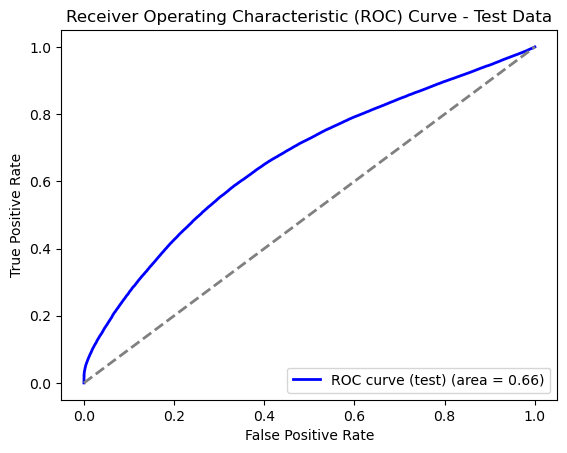

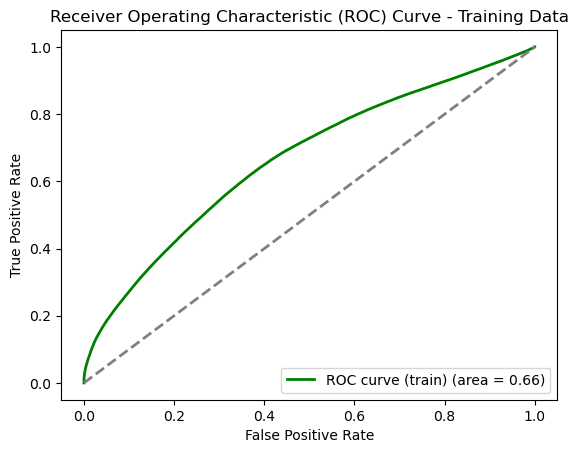

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize Logistic Regression model
model = LogisticRegression(
    max_iter=1000,   
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5375276757090253
Test Log Loss: 0.7941868157298279
Test ROC AUC: 0.7088797789577437
Test Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.89      0.54     77933
           1       0.89      0.38      0.54    178158

    accuracy                           0.54    256091
   macro avg       0.64      0.64      0.54    256091
weighted avg       0.74      0.54      0.54    256091

Train Accuracy: 0.6911629786933732
Train Log Loss: 0.5791975038765113
Train ROC AUC: 0.7588064500194245
Train Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70    311734
           1       0.71      0.66      0.68    311734

    accuracy                           0.69    623468
   macro avg       0.69      0.69      0.69    623468
weighted avg       0.69      0.69      0.69    623468



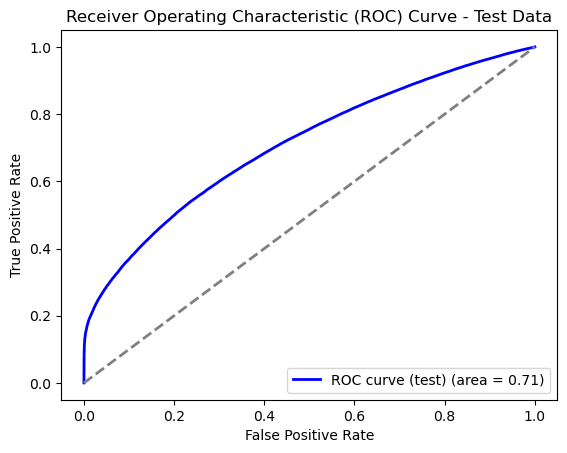

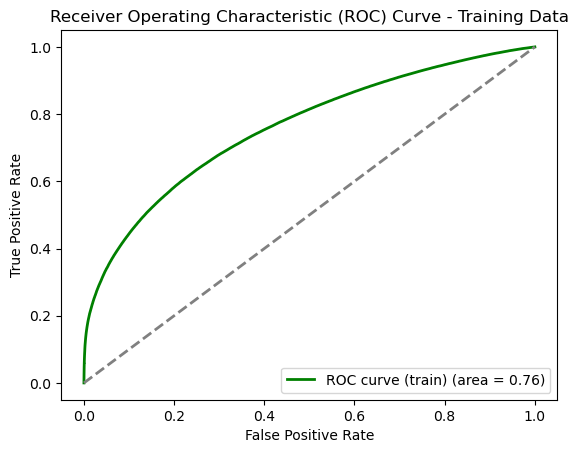

In [6]:
model = LogisticRegression(
    max_iter=2000,    # Increased iterations
    random_state=42,
    solver='liblinear',  # Suitable for small datasets or imbalanced classes
    class_weight='balanced',  # Handles class imbalance
    penalty='l2',  # Regularization (default)
    C=1.0  # Regularization strength (default)
)

model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.5933945355361961
Test Log Loss: 0.6861624209201527
Test ROC AUC: 0.6662493335984352
Test Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.71      0.52     77933
           1       0.81      0.54      0.65    178158

    accuracy                           0.59    256091
   macro avg       0.61      0.63      0.58    256091
weighted avg       0.69      0.59      0.61    256091

Train Accuracy: 0.6246880353121571
Train Log Loss: 0.6523930827280326
Train ROC AUC: 0.6648804797858476
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63    311734
           1       0.63      0.61      0.62    311734

    accuracy                           0.62    623468
   macro avg       0.62      0.62      0.62    623468
weighted avg       0.62      0.62      0.62    623468



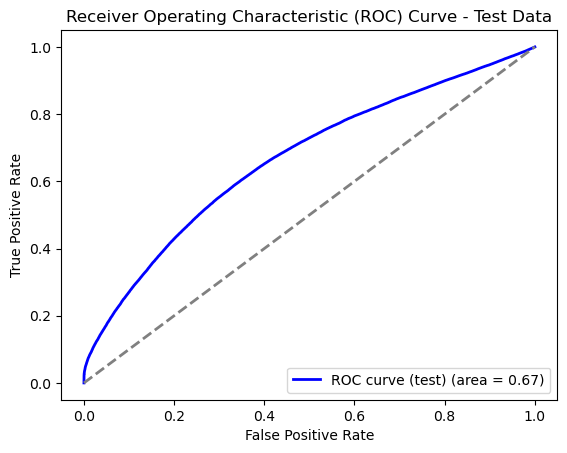

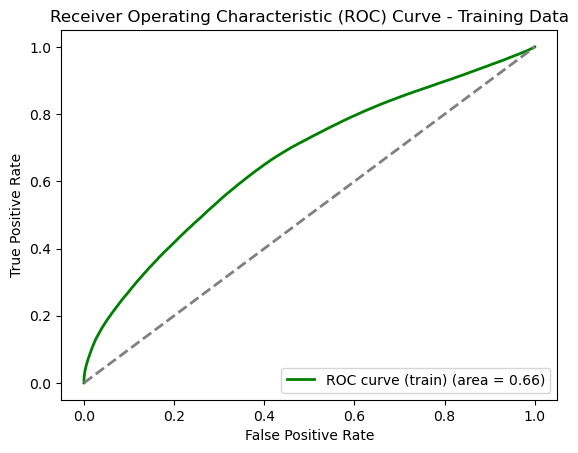

In [7]:
model = LogisticRegression(
    max_iter=1500,   # Slightly increased to allow better convergence
    random_state=42,
    class_weight='balanced'  # Address class imbalance
)

model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.712766165152231
Test Log Loss: 8.206318225002299
Test ROC AUC: 0.5709300101354835
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.20      0.29     77933
           1       0.73      0.94      0.82    178158

    accuracy                           0.71    256091
   macro avg       0.66      0.57      0.56    256091
weighted avg       0.68      0.71      0.66    256091

Train Accuracy: 0.5059682293237183
Train Log Loss: 11.815048406501234
Train ROC AUC: 0.5060454569400517
Train Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48    311734
           1       0.51      0.56      0.53    311734

    accuracy                           0.51    623468
   macro avg       0.51      0.51      0.50    623468
weighted avg       0.51      0.51      0.50    623468



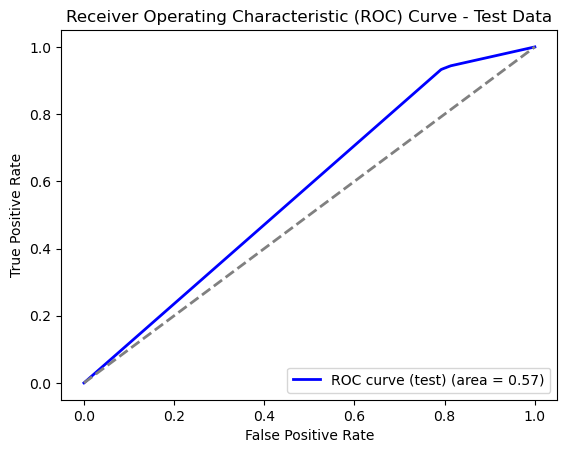

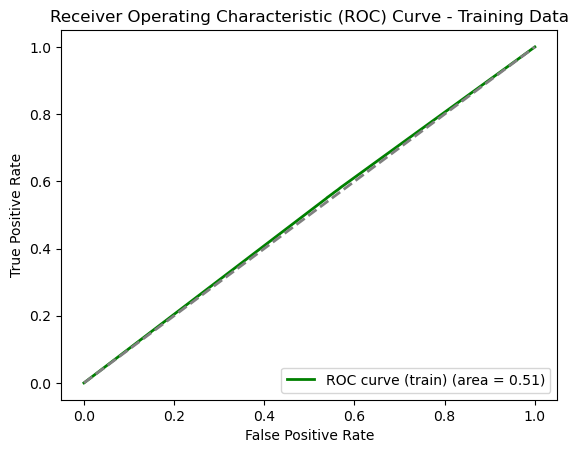

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the SVM model
model = SVC(probability=True, kernel='linear', max_iter=1000)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.676197133050361
Test Log Loss: 2.0788437431224938
Test ROC AUC: 0.5915775346860399
Test Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.27      0.33     77933
           1       0.73      0.85      0.79    178158

    accuracy                           0.68    256091
   macro avg       0.59      0.56      0.56    256091
weighted avg       0.64      0.68      0.65    256091

Train Accuracy: 0.7589322948411146
Train Log Loss: 0.4669078235854847
Train ROC AUC: 0.840842381283607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77    311734
           1       0.78      0.72      0.75    311734

    accuracy                           0.76    623468
   macro avg       0.76      0.76      0.76    623468
weighted avg       0.76      0.76      0.76    623468



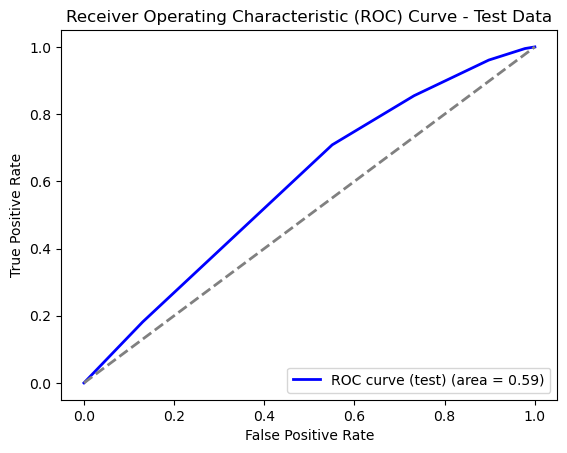

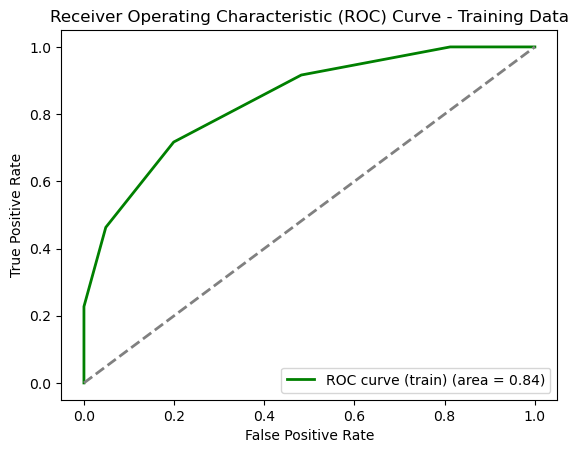

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5369966144846949
Test Log Loss: 0.7192147981280189
Test ROC AUC: 0.6782421297539286
Test Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.81      0.52     77933
           1       0.83      0.42      0.56    178158

    accuracy                           0.54    256091
   macro avg       0.61      0.61      0.54    256091
weighted avg       0.69      0.54      0.54    256091

Train Accuracy: 0.6128157339270018
Train Log Loss: 0.686217607973134
Train ROC AUC: 0.6779964553678767
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.79      0.67    311734
           1       0.67      0.44      0.53    311734

    accuracy                           0.61    623468
   macro avg       0.63      0.61      0.60    623468
weighted avg       0.63      0.61      0.60    623468



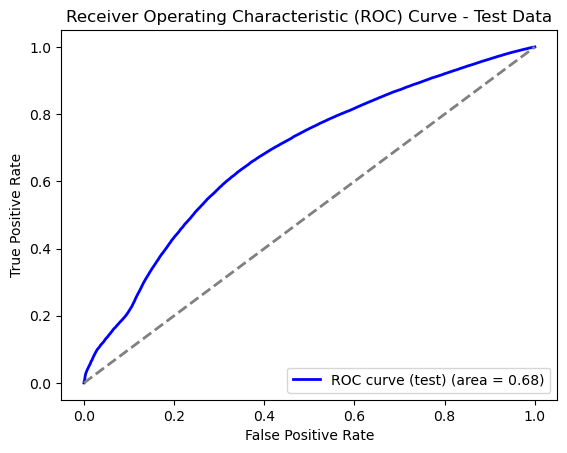

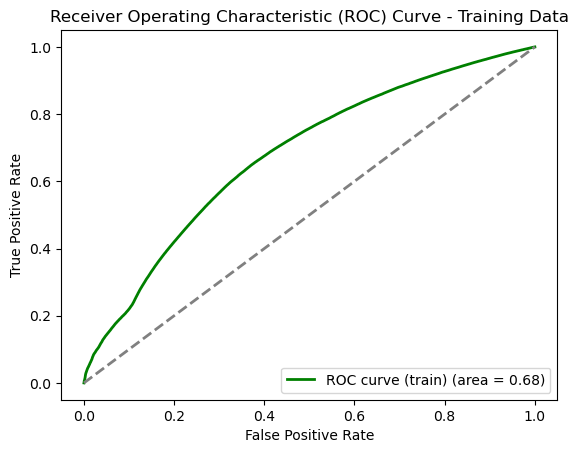

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the Naive Bayes model
model = GaussianNB() 
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Convert data to numeric types
X_train_numeric = np.array(X_train, dtype=np.float32)  
X_test_numeric = np.array(X_test, dtype=np.float32)    
y_train_numeric = np.array(y_train, dtype=np.float32)  
y_test_numeric = np.array(y_test, dtype=np.float32)    

# Reshape X_train and X_test to have a time step dimension (convert to 3D for RNN input)
X_train_reshaped = np.expand_dims(X_train_numeric, axis=1)  
X_test_reshaped = np.expand_dims(X_test_numeric, axis=1)

# Define the Simple RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba) 
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt


# Define the GRU model
model = Sequential([
    GRU(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                   
    learning_rate=0.05,             
    n_estimators=200,               
    subsample=0.8,                 
    random_state=42                 
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")